## Objectives:

 * Learn fundamental programming concepts and how to apply them with Python
    * How Python interprets code
    * Logic: if, and, or, etc.
    * Flow control: for loops
    * Objects: arrays, lists, dicts, etc.
 * Learn how to apply the scientific method for debugging code
 * Learn how to use iPython Notebook
 

## Overview

The week 1 lesson revolves around writing code to find and count precipitation events in a given precipitation dataset; the students will also determine event lengths.  This will require use of `for` statements to run through an array, `if`-statements to determine precipitation presence, `and` conditions to properly determine precipitation event existence, and `array` and `list` structures for tracking precipitation.  It will also provide an introduction into how Python generally works, and presumably it will also provide an introduction to debugging.  All of this will be done in iPython notebooks.


### Dataset details
I ordered the following dataset from NCDC:

```
	Order Summary
Order Number:	711323
Order Status:	Submitted
Order Format:	
Email Address:	taobrien@lbl.gov
Date Submitted:	2016-3-28 22:28 EST
 	Period of Request
Start Date:	1/1/2000
End Date:	1/1/2014
 	Requested Data
Custom Options:	Station name, Geographic location, Include data flags	
Stations:	COOP:042294 - DAVIS 2 WSW EXPERIMENTAL FARM, CA US
Data Types:	QGAG - Precipitation (10th or 100th of an inch)
QPCP - Precipitation (10th or 100th of an inch)
```

The downloaded file is contained in this repository: `data/711323.csv`

The dataset documentation is at [http://www1.ncdc.noaa.gov/pub/data/cdo/documentation/PRECIP_15_documentation.pdf](http://www1.ncdc.noaa.gov/pub/data/cdo/documentation/PRECIP_15_documentation.pdf)

## Instructor key

The following code shows how Travis went about writing code to accomplish the lesson's task.

### loading the data


    Length of qpcp:	3571
    Min of qpcp:	-9999.0
    Max of qpcp:	99999.0

        

    Length of qgag:	3571
    Min of qgag:	-9999.0
    Max of qgag:	99999.0

        


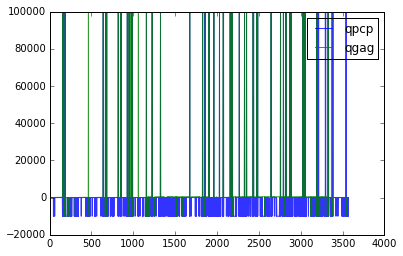

In [1]:
""" load the data file """
# use inline notebook plotting
# (only works within iPython Notebook)
%matplotlib inline 

# load plotting tools (commands prefixed with PP)
import pylab as PP

# load numpy tools into the default namespace
from numpy import *

# set the data file
data_file = 'data/711323.csv'

# load the data using numpy's `loadtxt()` function
# determined skiprows, usecols, and delimeter from opening
# and visually examining the data
input_data = loadtxt(data_file,skiprows=1,usecols=[6,10],delimiter=',')
qgag = input_data[:,0]
qpcp = input_data[:,1]

# set variables
precip_vars = {'qgag' : qgag, \
               'qpcp' : qpcp }

# Print dataset statistics
# note that I created the above `dict` (precip_vars)
# so that I could loop by variable name.
for var in precip_vars:
    
    # Print the variable name, length of variable, and min/max
    # the format statement fills in the stuff in curly brackets {}
    print( \
        """
    Length of {var}:\t{datalen}
    Min of {var}:\t{datamin}
    Max of {var}:\t{datamax}

        """.format(var=var, \
                   datalen=len(qgag), \
                   datamin=min(qgag), \
                   datamax=max(qgag), \
                  ))      

# loop over precip variables
for var in precip_vars:
    # create the plot
    PP.plot(precip_vars[var],alpha=0.8,label=var)

# add a legend
# loc sets the location ('best' has PP guess where to put it)
PP.legend(loc='best')
# draw the plot
PP.show()

#### comments

Note that [the dataset documentation](http://www1.ncdc.noaa.gov/pub/data/cdo/documentation/PRECIP_15_documentation.pdf) states that *The values
9999 or 99999 means the data value is missing.*  However, from looking at the above output, it is clear that -9999 is present quite often, as is 99999.  For simplicity, I will assume that anything with an absolute value of -9999 or 99999 is a missing value.

I've arbitrarily decided to go with the qpcp variable.

### dealing with bad data

In [2]:
# determine where data are bad
bad_data_mask = logical_or(abs(qpcp) == 9999, abs(qpcp) == 99999)

# use nonzero() to get indices of bad data
bad_indices = nonzero(bad_data_mask)[0]

# create a copy of qpcp with bad values replaces with 0
qpcp_inches = array(qpcp)
qpcp_inches[bad_indices] = 0.0

# convert units to inches (note the file has units flagged as 'HT' throughout)
# which the documentation says means tenth-inch
qpcp_inches /= 10

# plot it
PP.plot(qpcp_inches)
PP.xlabel('data value number')
PP.ylabel('precipitation rate [in]')
PP.show()

### counting precipitation events (the loop-based way)

In [3]:
# loop over the precipitation variable
number_of_events = 0

# initialize the event counter to 0
num_events = 0

# inialize the 'in_precip' flag
in_precip = False

# initialize the event lengths list
event_lengths = []

# initialize the current event length
current_length = 0

# loop over indices of the qpcp_inches variable
for i in range(len(qpcp_inches)):
    
    # determine if this is a precipitation event
    if qpcp_inches[i] > 0:
        is_precip = True
    else:
        # flag that this isn't a precip event
        is_precip = False
        
    # determine if we are already in a precipitation event
    if is_precip:
        # check if we are in a precip event
        if in_precip:
            # increment the current event length counter
            current_length = current_length + 1
            
        else:
            # flag that we are now in a precipitation event
            in_precip = True

            # increment the event counter
            num_events = num_events + 1
            
            # set the current event length counter to 1
            current_length = 1
    else:
        # check if we were in a precip event
        if in_precip:
            # if so, the current event has ended; add it to the list
            event_lengths.append(current_length)
            
        # if this isn't a precip event, flag that we aren't in a precip
        # event
        in_precip = False

In [4]:
# print the number of events
print('Total number of events: {}'.format(num_events))

# plot a histogram of event lengths
PP.hist(event_lengths)
PP.xlabel('Number of events')
PP.ylabel('Count')
PP.show()

Total number of events: 306


### counting precipitation events (the vector-based way)

In [5]:
# generate a mask of precipitation events
# (1 where there is precipitation, 0 otherwise)
is_precip_event = array(qpcp_inches > 0,dtype=int)

# use diff() to determine when precipitation events end and begin
# will be 1 for the start of an event and -1 for the end of one
precip_bounds = diff(is_precip_event)

# count the number of beginnings and ends
num_beginning = sum(precip_bounds == 1)
num_end = sum(precip_bounds == -1)

# print the number of beginnings and ends; should be equal if we have
# a complete set of events
print "Number of beginnings : {}, Number of ends {}".format(num_beginning, num_end)

# check whether the first event is a beginning
# get the index of the first event boundary
i_first_bound = nonzero(precip_bounds != 0)[0][0]

# print the boundary; should be 1 if the first event is a beginning
print "First event boudnary: " + str(precip_bounds[i_first_bound])

# assuming this all checked out, the number of events is the number
# of beginnings
num_events = num_beginning

# get the event lengths: use the difference between the event start
# and end indices
i_beginning = nonzero(precip_bounds == 1)[0]
i_end = nonzero(precip_bounds == -1)[0]
event_lengths = i_end - i_beginning

Number of beginnings : 306, Number of ends 306
First event boudnary: 1


Total number of events: 306


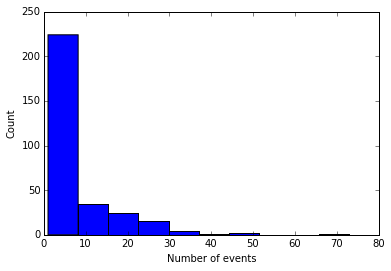

In [6]:
# print the number of events
print('Total number of events: {}'.format(num_events))

# plot a histogram of event lengths
PP.hist(event_lengths)
PP.xlabel('Number of events')
PP.ylabel('Count')
PP.show()

## What to provide students
The following code is what should be provided to students at the beginning of class:

In [7]:
""" load the data file and plot it"""
# use inline notebook plotting
# (only works within iPython Notebook)
%matplotlib inline 

# load plotting tools (commands prefixed with PP)
import pylab as PP

# load numpy tools into the default namespace
from numpy import *

# load a library for downloading files
import urllib

try:
    # get the data file
    urllib.urlretrieve('https://bitbucket.org/taobrienucd/taobrienucd.bitbucket.org/raw/master/data/711323.csv','711323.csv')
except:
    raise RuntimeError,u"Could not download CSV file; let Travis or Héctor know"

    
try:
    # set the data file
    data_file = '711323.csv'

    # load the data using numpy's `loadtxt()` function
    # determined skiprows, usecols, and delimeter from opening
    # and visually examining the data
    qpcp = loadtxt(data_file,skiprows=1,usecols=[10],delimiter=',')
except:
    raise RuntimeError,u"Could not open downloaded CSV file; let Travis or Héctor know"


# determine where data are bad
bad_data_mask = logical_or(abs(qpcp) == 9999, abs(qpcp) == 99999)

# use nonzero() to get indices of bad data
bad_indices = nonzero(bad_data_mask)[0]

# create a copy of qpcp with bad values replaces with 0
qpcp_inches = array(qpcp)
qpcp_inches[bad_indices] = 0.0

# convert units to inches (note the file has units flagged as 'HT' throughout)
# which the documentation says means tenth-inch
qpcp_inches *= 10

# define a function for evaluating output
def plot_events(num_events,event_lengths):
    """ Given a number of events and a list of event lengths, generate a plot.
    
        input:
        -----
            num_events : an integer giving the number of events
            event_lengths : an array-like object (1D) of event lengths
            
        output:
        ------
        
            Generates a histogram of event lengths.
    """
    # check for consistency between num_events and event_lengths
    assert num_events == len(event_lengths), "Error: there are somehow more events in event_lengths than in num_events"
    
    # plot a histogram of event lengths
    PP.hist(event_lengths)
    PP.xlabel('Number of events')
    PP.ylabel('Count')
    PP.title('Total #: {}'.format(num_events))
    PP.show()

# plot it
PP.plot(qpcp_inches)
PP.xlabel('data value number')
PP.ylabel('precipitation rate [in]')
PP.show()

The following code is what should be provided to students at the end of class:

In [8]:
plot_events(num_events,event_lengths)